In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc

In [ ]:
path = kagglehub.dataset_download("nih-chest-xrays/data")
print("Path to dataset files:", path)

100%|██████████| 42.0G/42.0G [13:23<00:00, 56.1MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [ ]:
# Load metadata
all_xray_df = pd.read_csv('/root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('/root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3', 'images*', 'images', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

Scans found: 112120 , Total Headers 112120


In [ ]:
# Map image paths to DataFrame
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

In [ ]:
# Data cleaning and label encoding
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [ ]:
# Create binary columns for each label
for c_label in all_labels:
    if len(c_label) > 1:  # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)


In [ ]:
# Filter labels with at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum() > MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)),
      [(c_label, int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


In [ ]:
# Resample the dataset
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x) > 0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

In [ ]:
# Split data into training and validation sets
train_df, valid_df = train_test_split(all_xray_df, test_size=0.25, random_state=2018,
                                      stratify=all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


In [ ]:
# Create data generators
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(rescale=1.0 / 255.0)

train_gen = core_idg.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col='Finding Labels',
    class_mode='categorical',
    classes=all_labels,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=32
)

valid_gen = core_idg.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col='Finding Labels',
    class_mode='categorical',
    classes=all_labels,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=256
)

# Create a test batch
test_X, test_Y = next(core_idg.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col='Finding Labels',
    class_mode='categorical',
    classes=all_labels,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=1024
))

Found 14403 validated image filenames belonging to 13 classes.
Found 4888 validated image filenames belonging to 13 classes.
Found 4888 validated image filenames belonging to 13 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten

In [ ]:
# Build VGG16 model
base_vgg16_model = VGG16(input_shape=(128, 128, 1), include_top=False, weights=None)
multi_disease_model = Sequential()
multi_disease_model.add(base_vgg16_model)
multi_disease_model.add(Flatten())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512, activation='relu'))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation='sigmoid'))
multi_disease_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14713536  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 13)                6669      
                                                                 
Total params: 18915021 (72.16 MB)
Trainable params: 1891

In [ ]:
# Callbacks
weight_path = "vgg16_xray_class.weights.h5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
# Train the model
multi_disease_model.fit(train_gen,
                        steps_per_epoch=100,
                        validation_data=(test_X, test_Y),
                        epochs=5,
                        callbacks=callbacks_list)

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.8524 - binary_accuracy: 0.9012 - mae: 0.1761
Epoch 1: val_loss improved from inf to 0.23900, saving model to vgg16_xray_class.weights.h5
100/100 [==============================] - 248s 2s/step - loss: 0.8524 - binary_accuracy: 0.9012 - mae: 0.1761 - val_loss: 0.2390 - val_binary_accuracy: 0.9231 - val_mae: 0.1417
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.2447 - binary_accuracy: 0.9219 - mae: 0.1347
Epoch 2: val_loss improved from 0.23900 to 0.23889, saving model to vgg16_xray_class.weights.h5
100/100 [==============================] - 198s 2s/step - loss: 0.2447 - binary_accuracy: 0.9219 - mae: 0.1347 - val_loss: 0.2389 - val_binary_accuracy: 0.9231 - val_mae: 0.1388
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.2441 - binary_accuracy: 0.9224 - mae: 0.1339
Epoch 3: val_loss improved from 0.23889 to 0.23777, saving model to vgg16_xray_class.weights.h5
100/100 [===

In [ ]:
# Evaluate the model
pred_Y = multi_disease_model.predict(test_X, batch_size=32, verbose=True)

32/32 [==============================] - 12s 367ms/step


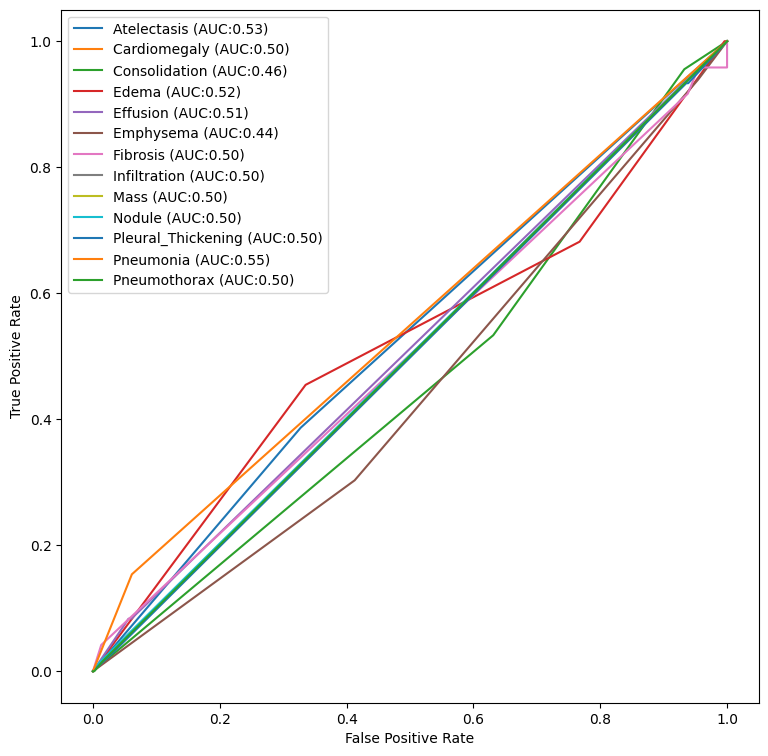

In [ ]:
# Plot ROC curves
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), pred_Y[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('vgg16_trained_net.png')

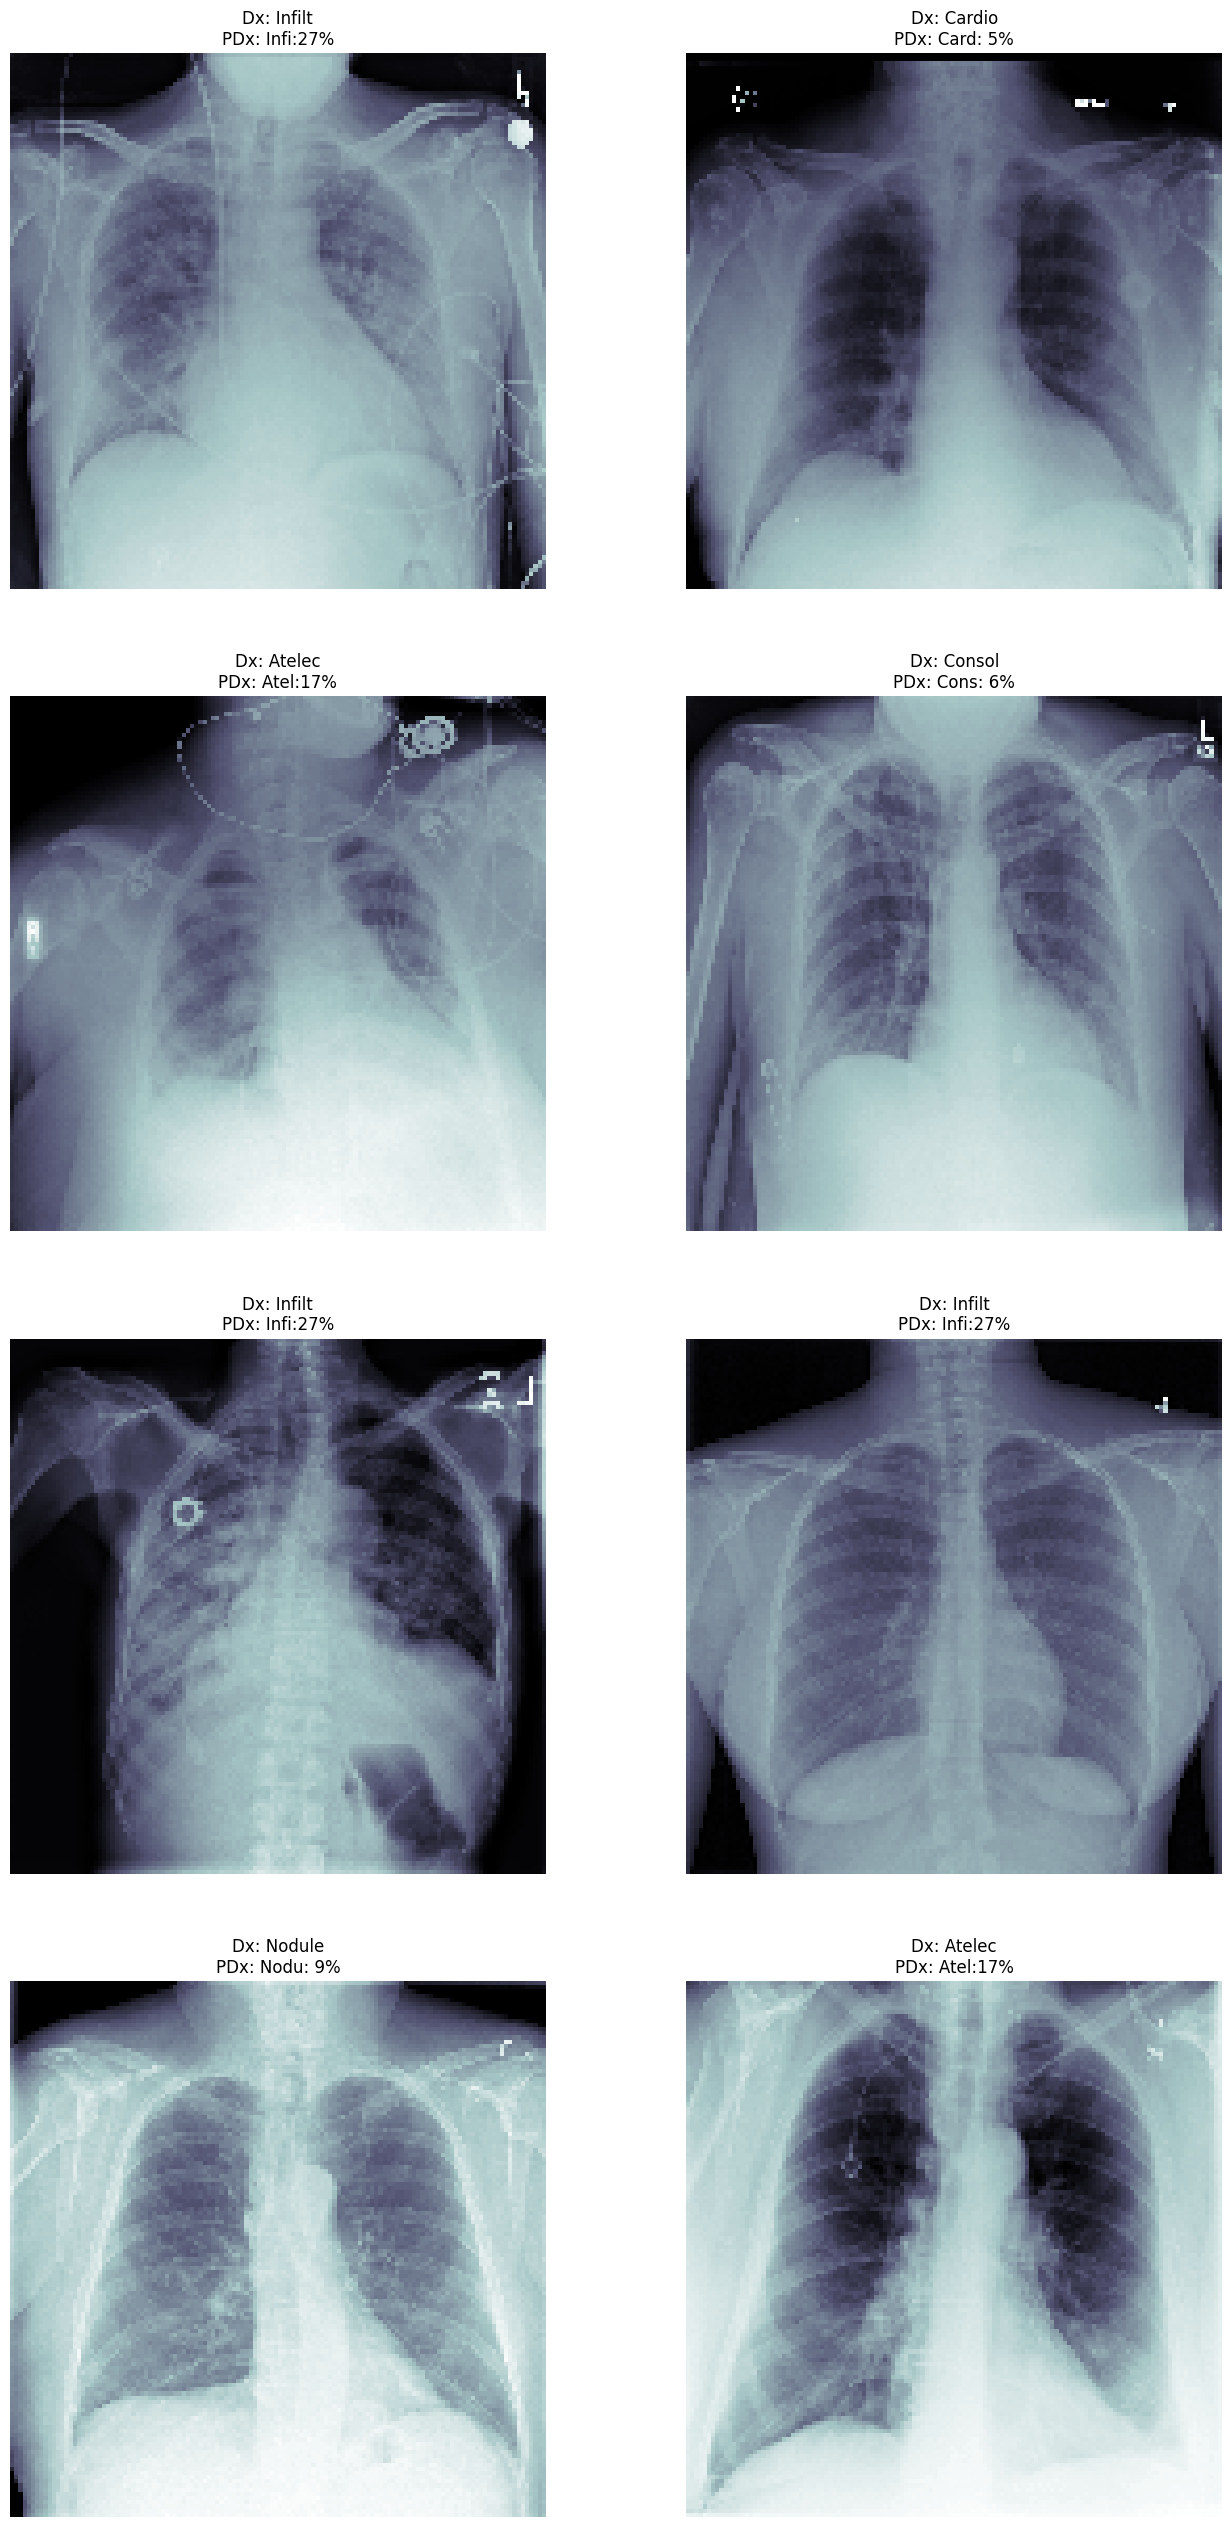

In [ ]:
# Visualize predictions
sickest_idx = np.argsort(np.sum(test_Y, 1) < 1)
fig, m_axs = plt.subplots(4, 2, figsize=(16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :, :, 0], cmap='bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, test_Y[idx]) if n_score > 0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score * 100) for n_class, n_score, p_score in zip(all_labels, test_Y[idx], pred_Y[idx]) if (n_score > 0.5) or (p_score > 0.5)]
    c_ax.set_title('Dx: ' + ', '.join(stat_str) + '\nPDx: ' + ', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('vgg16_trained_img_predictions.png')